# Feature Engineering for High-Frequency Data

## Imports & Settings

In [3]:
%matplotlib inline
import sys, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, NATR

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Data prep

We use the 'Trade and Quote' dataset.

In [3]:
as_path = Path('../data/nasdaq100')

In [4]:
tcols = ['openbartime', 'firsttradetime',
         'highbidtime', 'highasktime', 'hightradetime',
         'lowbidtime', 'lowasktime', 'lowtradetime',
         'closebartime', 'lasttradetime']

In [5]:
drop_cols = ['unknowntickvolume',
             'cancelsize',
             'tradeatcrossorlocked']

In [6]:
keep = ['firsttradeprice', 'hightradeprice', 'lowtradeprice', 'lasttradeprice', 
        'minspread', 'maxspread',
        'volumeweightprice', 'nbboquotecount', 
        'tradeatbid', 'tradeatbidmid', 'tradeatmid', 'tradeatmidask', 'tradeatask', 
        'volume', 'totaltrades', 'finravolume', 
        'finravolumeweightprice', 
        'uptickvolume', 'downtickvolume', 
        'repeatuptickvolume', 'repeatdowntickvolume', 
        'tradetomidvolweight', 'tradetomidvolweightrelative']

In [7]:
columns = {'volumeweightprice'          : 'price',
           'finravolume'                : 'fvolume',
           'finravolumeweightprice'     : 'fprice',
           'uptickvolume'               : 'up',
           'downtickvolume'             : 'down',
           'repeatuptickvolume'         : 'rup',
           'repeatdowntickvolume'       : 'rdown',
           'firsttradeprice'            : 'first',
           'hightradeprice'             : 'high',
           'lowtradeprice'              : 'low',
           'lasttradeprice'             : 'last',
           'nbboquotecount'             : 'nbbo',
           'totaltrades'                : 'ntrades',
           'openbidprice'               : 'obprice',
           'openbidsize'                : 'obsize',
           'openaskprice'               : 'oaprice',
           'openasksize'                : 'oasize',
           'highbidprice'               : 'hbprice',
           'highbidsize'                : 'hbsize',
           'highaskprice'               : 'haprice',
           'highasksize'                : 'hasize',
           'lowbidprice'                : 'lbprice',
           'lowbidsize'                 : 'lbsize',
           'lowaskprice'                : 'laprice',
           'lowasksize'                 : 'lasize',
           'closebidprice'              : 'cbprice',
           'closebidsize'               : 'cbsize',
           'closeaskprice'              : 'caprice',
           'closeasksize'               : 'casize',
           'firsttradesize'             : 'firstsize',
           'hightradesize'              : 'highsize',
           'lowtradesize'               : 'lowsize',
           'lasttradesize'              : 'lastsize',
           'tradetomidvolweight'        : 'volweight',
           'tradetomidvolweightrelative': 'volweightrel'}

In [8]:
def data_to_hdf():
    parquet_path = as_path / '1min_taq' / 'parquet'
    files = list(parquet_path.glob('*.parquet'))
    for year in range(2013, 2018):
        print(year)
        data = []
        for f in files:
            if f.stem.startswith(str(year)):
                # print(f.stem, end=' ', flush=True)
                data.append(pd.read_parquet(f).drop(tcols + drop_cols, axis=1))
        data = (pd.concat(data).sort_index()
                .reset_index('ticker')
                .between_time('9:30', '16:00')
                .set_index('ticker', append=True)
                .swaplevel()
                .rename(columns=columns)
                .rename(columns=lambda x: x.replace('tradeat', 'at')))
        print(data.info(null_counts=True))
        data.to_hdf('algoseek.h5', f'data/{year}')

In [9]:
# data_to_hdf()

## Loading Algoseek Data

In [11]:
ohlcv_cols = ['first', 'high', 'low', 'last', 'price', 'volume']

In [12]:
data_cols = ohlcv_cols + ['up', 'down', 'rup', 'rdown', 'atask', 'atbid']

In [13]:
years = range(2013, 2018)
with pd.HDFStore('algoseek.h5') as store:
    df = (pd.concat([store[f'data/{year}']
                     .loc[:, data_cols] for year in years])
          .sort_index())

In [14]:
df.loc[:, ohlcv_cols[:4]] = df.loc[:, ohlcv_cols[:4]].groupby('ticker').fillna(method='ffill')

In [15]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51242505 entries, ('AAL', Timestamp('2014-12-22 09:30:00')) to ('YHOO', Timestamp('2017-06-16 16:00:00'))
Data columns (total 12 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   first   51242500 non-null  float64
 1   high    51242500 non-null  float64
 2   low     51242500 non-null  float64
 3   last    51242500 non-null  float64
 4   price   49242369 non-null  float64
 5   volume  51242505 non-null  int64  
 6   up      51242505 non-null  int64  
 7   down    51242505 non-null  int64  
 8   rup     51242505 non-null  int64  
 9   rdown   51242505 non-null  int64  
 10  atask   51242505 non-null  int64  
 11  atbid   51242505 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 6.1+ GB


In [16]:
df.to_hdf('hf_data.h5', 'data')

In [3]:
df = pd.read_hdf('hf_data.h5', 'data')
# .loc[idx['AAPL', '2013'], :]

## Feature Engineering

All of the features above were normalized in a standard fashion
by subtracting their means, dividing by their standard deviations, and time-averaging over a recent
interval. In order to obtain a finite state space, features were discretized into bins in multiples of
standard deviation units

In [17]:
df = df.sort_index()
df['date'] = pd.to_datetime(df.index.get_level_values('date_time').date)

In [23]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51242505 entries, ('AAL', Timestamp('2014-12-22 09:30:00')) to ('YHOO', Timestamp('2017-06-16 16:00:00'))
Data columns (total 13 columns):
 #   Column  Non-Null Count     Dtype         
---  ------  --------------     -----         
 0   first   51242500 non-null  float64       
 1   high    51242500 non-null  float64       
 2   low     51242500 non-null  float64       
 3   last    51242500 non-null  float64       
 4   price   49242369 non-null  float64       
 5   volume  51242505 non-null  int64         
 6   up      51242505 non-null  int64         
 7   down    51242505 non-null  int64         
 8   rup     51242505 non-null  int64         
 9   rdown   51242505 non-null  int64         
 10  atask   51242505 non-null  int64         
 11  atbid   51242505 non-null  int64         
 12  date    51242505 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(7)
memory usage: 5.3+ GB


In [19]:
by_ticker = df.groupby('ticker', group_keys=False)
by_ticker_date = df.groupby(['ticker', 'date'])

In [20]:
data = pd.DataFrame(index=df.index)

In [21]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [22]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('date_time').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

### Lagged Returns

In [32]:
for t in range(1, 11):
    print(t, end=' ', flush=True)
    data[f'ret{t}min'] = (df
                          .sort_index()
                          .groupby(['ticker', 'date'])
                          .price
                          .pct_change(periods=t, fill_method=None)
                          .shift())

1 2 3 4 5 6 7 8 9 10 

### Forward Returns

In [33]:
data['fwd1min'] = (data
                   .sort_index()
                   .groupby(['ticker', 'date'])
                   .ret1min
                   .shift(-1))

In [34]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51242505 entries, ('AAL', Timestamp('2014-12-22 09:30:00')) to ('YHOO', Timestamp('2017-06-16 16:00:00'))
Data columns (total 14 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   date      51242505 non-null  int64  
 1   minute    51242505 non-null  int64  
 2   ret1min   47691042 non-null  float64
 3   ret2min   47538643 non-null  float64
 4   ret3min   47404303 non-null  float64
 5   ret4min   47278796 non-null  float64
 6   ret5min   47156138 non-null  float64
 7   ret6min   47020881 non-null  float64
 8   ret7min   46889480 non-null  float64
 9   ret8min   46762328 non-null  float64
 10  ret9min   46633223 non-null  float64
 11  ret10min  46511734 non-null  float64
 12  fwd1min   47691042 non-null  float64
 13  price     49242369 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 5.6+ GB


### Normalized up/downtick volume

In [57]:
data['rup'] = df.rup.div(df.volume)
data['up'] = df.up.div(df.volume)
data['down'] = df.down.div(df.volume)
data['rdown'] = df.rdown.div(df.volume)
for f in ['up', 'down', 'rup', 'rdown']:
    data[f] = data.groupby(['ticker', 'date'])[f].shift()

### Balance of Power

In [36]:
data['BOP'] = (by_ticker
               .apply(lambda x: talib.BOP(x['first'],
                                          x.high,
                                          x.low,
                                          x['last'])
                      .shift()))

###  Commodity Channel Index

In [37]:
data['CCI'] = (by_ticker
               .apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x['last'],
                                          timeperiod=14).shift()))

### Money Flow Index

In [38]:
data['MFI'] = (by_ticker
               .apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x['last'],
                                          x.volume,
                                          timeperiod=14)
                      .shift()))

### Stochastic RSI

In [40]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x['last'],
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]
                                    .shift()))

### Stochastic

In [42]:
def compute_stoch(x, fastk_period=14, slowk_period=3, 
                  slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high, x.low, x['last'],
                           fastk_period=fastk_period,
                           slowk_period=slowk_period,
                           slowk_matype=slowk_matype,
                           slowd_period=slowd_period,
                           slowd_matype=slowd_matype)
    return (slowd/slowk-1).shift()

In [43]:
data['STOCH'] = by_ticker.apply(compute_stoch).replace((np.inf, -np.inf), np.nan)

### Transaction Volume by price point

In [45]:
data['trades_bid_ask'] = df.atask.sub(df.atbid).div(df.volume).replace((np.inf, -np.inf), np.nan)
data['trades_bid_ask'] = data.groupby(['ticker', 'date']).trades_bid_ask.shift()

### Evaluate features

In [59]:
features = ['ret1min', 'ret2min', 'ret3min', 'ret4min', 'ret5min', 
            'ret6min', 'ret7min', 'ret8min', 'ret9min', 'ret10min',
            'rup', 'up', 'down', 'rdown', 
            'BOP', 'CCI', 'MFI', 'STOCHRSI', 'STOCH', 
            'trades_bid_ask']

In [60]:
ic = {}
for feature in features:
    print(feature)
    df_ = data[['fwd1min', feature]].dropna()
    ic[feature] = spearmanr(df_.fwd1min, df_[feature])
ic = pd.Series(ic).apply(pd.Series)
ic.columns = ['IC', 'p-value']    

In [61]:
ic.sort_values('IC')

,IC,p-value
STOCHRSI,-0.012161,0.000000e+00
rup,-0.008730,0.000000e+00
CCI,-0.008702,0.000000e+00
trades_bid_ask,-0.007411,0.000000e+00
BOP,-0.006446,0.000000e+00
MFI,-0.003607,5.702215e-137
up,0.000075,6.058337e-01
down,0.002202,2.631280e-51
rdown,0.009543,0.000000e+00
STOCH,0.009694,0.000000e+00


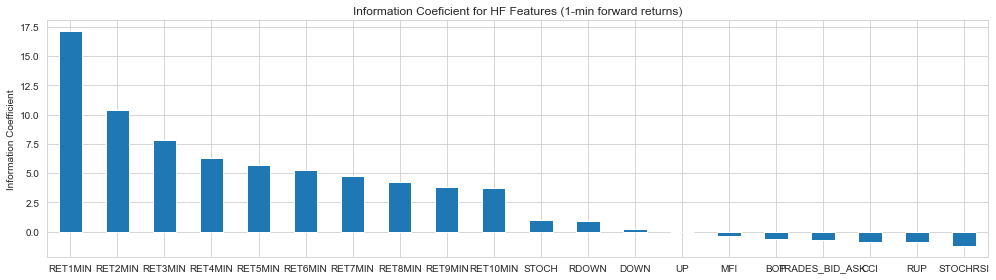

In [21]:
ic.index = ic.index.map(str.upper)
ax = ic['IC'].sort_values(ascending=False).mul(100).plot.bar(figsize=(14, 4), 
                                                        title='Information Coeficient for HF Features (1-min forward returns)',
                                                       rot=0)
ax.set_ylabel('Information Coefficient')
plt.tight_layout()
plt.savefig('figures/hft_ic', dpi=300);

In [63]:
ic.sort_values('IC').to_csv('hf_ic.csv')

### Store results

In [65]:
data.drop(['date', 'up', 'down'], axis=1).to_hdf('hf_data.h5', 'model_data')

In [64]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 51242505 entries, ('AAL', Timestamp('2014-12-22 09:30:00')) to ('YHOO', Timestamp('2017-06-16 16:00:00'))
Data columns (total 24 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   date            51242505 non-null  int64  
 1   minute          51242505 non-null  int64  
 2   ret1min         47691042 non-null  float64
 3   ret2min         47538643 non-null  float64
 4   ret3min         47404303 non-null  float64
 5   ret4min         47278796 non-null  float64
 6   ret5min         47156138 non-null  float64
 7   ret6min         47020881 non-null  float64
 8   ret7min         46889480 non-null  float64
 9   ret8min         46762328 non-null  float64
 10  ret9min         46633223 non-null  float64
 11  ret10min        46511734 non-null  float64
 12  fwd1min         47691042 non-null  float64
 13  price           49242369 non-null  float64
 14  rup             49398844 non-null  flo